EXPERIMENT 8: Fine Tuning Pretrained CNN Architecture

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.layers import Flatten , Dense
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, ImageDataGenerator

In [3]:
!unzip images.zip
traindf = pd.read_csv("emergency_train.csv" , dtype = str)
traindf.head(10)

Archive:  images.zip
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg         
  inflating: images/102.jpg  

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
5,45.jpg,1
6,2313.jpg,0
7,1657.jpg,0
8,294.jpg,1
9,999.jpg,0


In [4]:
train_datgen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [20]:
test_datagen = ImageDataGenerator(rescale =  1./255 , validation_split = 0.10)

In [7]:
valid_datagen = ImageDataGenerator(rescale = 1./255 , validation_split = 0.15)

In [12]:
train_generator = train_datgen.flow_from_dataframe(
    dataframe = traindf,
    directory = "images",
    x_col = 'image_names' ,
    y_col = 'emergency_or_not' , 
    subset = "training" , 
    batch_size =16 , 
    seed =42 ,
    shuffle = True ,
    class_mode = "binary" , 
    target_size = (224 ,224))


Found 1646 validated image filenames belonging to 2 classes.


In [21]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe =  traindf,
    directory = "images",
    x_col = 'image_names',
    y_col = 'emergency_or_not',
    subset = "validation",
    batch_size = 16,
    seed =42,
    shuffle =True,
    class_mode = "binary",
    target_size = (224 , 224)
)

Found 164 validated image filenames belonging to 2 classes.


In [25]:
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = "images",
    x_col = 'image_names',
    y_col = 'emergency_or_not',
    subset = "validation" ,
    batch_size =  16,
    seed = 42,
    shuffle = True,
    class_mode = "binary",
    target_size = (224,224))

Found 246 validated image filenames belonging to 2 classes.


In [29]:
vgg = VGG16(include_top = False , weights = 'imagenet' ,  input_shape = (224, 224, 3))

for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs =  vgg.input , outputs = x)
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
model.summary()
train_generator.class_indices

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

{'0': 0, '1': 1}

In [31]:
history = model.fit_generator(train_generator , epochs =5 , validation_data =  valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
103/103 [==============================] - 52s 198ms/step - loss: 0.4984 - accuracy: 0.7494 - val_loss: 0.2631 - val_accuracy: 0.8780
Epoch 2/5
103/103 [==============================] - 18s 178ms/step - loss: 0.2326 - accuracy: 0.8915 - val_loss: 0.1376 - val_accuracy: 0.9472
Epoch 3/5
103/103 [==============================] - 18s 179ms/step - loss: 0.2032 - accuracy: 0.9252 - val_loss: 0.2685 - val_accuracy: 0.8740
Epoch 4/5
103/103 [==============================] - 18s 179ms/step - loss: 0.1528 - accuracy: 0.9317 - val_loss: 0.0989 - val_accuracy: 0.9756
Epoch 5/5
103/103 [==============================] - 18s 179ms/step - loss: 0.1184 - accuracy: 0.9617 - val_loss: 0.1051 - val_accuracy: 0.9634


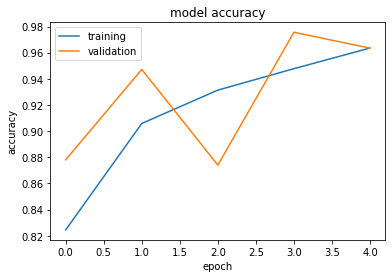

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training' , 'validation'] , loc = 'best')
plt.show()

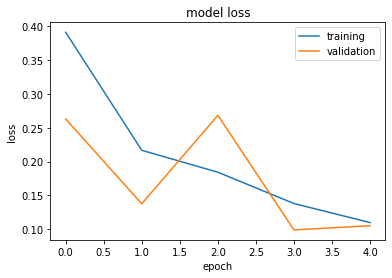

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training' , 'validation'] , loc = 'best')
plt.show()

In [35]:
scores = model.evaluate_generator(test_generator ,  steps =50)
print("%s: %2f%%" %(model.metrics_names[1] , scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


accuracy: 95.121950%
